# Machine Learning Engineer Nanodegree

## Capstone Project

### Project: Semantic similarity extraction using word vectors in Mahabharata dataset

Welcome to the capstone project of the Machine Learning Engineer Nanodegree! In this notebook, we will use corpus of words from Mahabharata is used as an input to create word vectors using word2vec, with the help of t-SNE, reduce the dimensions of the word vectors and finally use cosine similarity to analyze semantic similarities, i.e. to answer relationship questions based on the learning. The end solution of this project will be to analyze relationships and logics in the dataset. 

The dataset for this project can be found on the [GitHub Mahabharata Machine Learning Repository](https://github.com/TilakD/Mahabharata_extract-semantic-similarities_Natural-languageprocessing/tree/master/Dataset)

Model is assessed using the real facts about the data set, to benchmark the model I have compiled 23 relationship facts and will be adding few more as I build the model. For example, below are a few of the real data used to benchmark the model.
Dhritarastra is related to Pandu, as Sahadeva is related to Nakula

    Bhima is related to Arjuna, as Ambalika is related to Ambika
    Pandu is related to Kunti, as Dhritarashtra is related to Gandhari
    Bhima is related to Draupadi, as Arjuna is related to Chitrangada
    Karna is related to Kunti, as Duryodhana is related to Gandhari
    .
    .
    .


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Exploring the Data
Run the code cell below to load necessary Python libraries.

In [1]:
#future is the missing compatibility layer between Python 2 and Python 3. 
#It allows you to use a single, clean Python 3.x-compatible codebase to 
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

In [2]:
#word encoding
import codecs
#finds all pathnames matching a pattern, like regex
import glob
#log events for libraries
import logging
#concurrency
import multiprocessing
#dealing with operating system
import os
#pretty print, human readable
import pprint
#regular expressions
import re
#natural language toolkit
import nltk
#word 2 vec   (conda install -c anaconda gensim=1.0.1)
import gensim.models.word2vec as w2v
#dimensionality reduction
import sklearn.manifold
#math
import numpy as np
#plotting
import matplotlib.pyplot as plt
#parse dataset
import pandas as pd
#visualization (conda install -c anaconda seaborn=0.7.1)
import seaborn as sns

C:\Users\DTILAK\AppData\Local\Continuum\Anaconda2\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Set up logging

In [4]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Download NLTK tokenizer models (only the first time)

In [5]:
##stopwords like the at a an, unnecesasry
##tokenization into sentences, punkt 
##http://www.nltk.org/

nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DTILAK\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DTILAK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Preparing Corpus
### Load all 18 books

In [6]:
#get the book names, matching txt file
book_filenames = sorted(glob.glob("..\Mahabharata_extract-semantic-similarities_Natural-languageprocessing\input\*.txt"))
print("Found book:")
book_filenames

Found book:


['..\\Mahabharata_extract-semantic-similarities_Natural-languageprocessing\\input\\1-18 books combined.txt']

### Combine the book into one string

In [7]:
#initialize raw unicode , we'll add all text to this file in memory
corpus_raw = u""

#for each book, read it, open it in utf 8 format, 
#add it to the raw corpus
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print ("Corpus is now {0} characters long".format(len(corpus_raw)))
    print ()

Reading '..\Mahabharata_extract-semantic-similarities_Natural-languageprocessing\input\1-18 books combined.txt'...
Corpus is now 1704913 characters long



### Split the corpus into sentences

In [8]:
#tokenizastion
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [9]:
#tokenize into sentences
raw_sentences = tokenizer.tokenize(corpus_raw)

In [10]:
#convert into a list of words
#remove unnnecessary, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [11]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [12]:
# Example
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

Above all these qualities, he was a devoted servant of Lord Vishnu, and therefore he was given the title, "King of kings".
[u'Above', u'all', u'these', u'qualities', u'he', u'was', u'a', u'devoted', u'servant', u'of', u'Lord', u'Vishnu', u'and', u'therefore', u'he', u'was', u'given', u'the', u'title', u'King', u'of', u'kings']


In [13]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens.".format(token_count))

The book corpus contains 293,443 tokens.


### Build model

In [14]:
# Dimensionality of the resulting word vectors.
# more dimensions, more computationally expensive to train
# but also more accurate
# more dimensions = more generalized
num_features = 500

# Minimum word count threshold.
min_word_count = 7

# Number of threads to run in parallel.
# more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 25

# Downsample setting for frequent words.
# 0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the random number generator, to make the results reproducible.
seed = 1

In [15]:
mahabharata2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [16]:
mahabharata2vec.build_vocab(sentences)

2017-03-27 04:50:46,769 : INFO : collecting all words and their counts
2017-03-27 04:50:46,773 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-03-27 04:50:46,812 : INFO : PROGRESS: at sentence #10000, processed 170274 words, keeping 9385 word types
2017-03-27 04:50:46,848 : INFO : collected 11426 word types from a corpus of 293443 raw words and 17714 sentences
2017-03-27 04:50:46,848 : INFO : Loading a fresh vocabulary
2017-03-27 04:50:46,862 : INFO : min_count=7 retains 3271 unique words (28% of original 11426, drops 8155)
2017-03-27 04:50:46,865 : INFO : min_count=7 leaves 276186 word corpus (94% of original 293443, drops 17257)
2017-03-27 04:50:46,882 : INFO : deleting the raw counts dictionary of 11426 items
2017-03-27 04:50:46,884 : INFO : sample=0.001 downsamples 56 most-common words
2017-03-27 04:50:46,888 : INFO : downsampling leaves estimated 202700 word corpus (73.4% of prior 276186)
2017-03-27 04:50:46,892 : INFO : estimated required memory fo

In [17]:
print("Word2Vec vocabulary length:", len(mahabharata2vec.wv.vocab))

Word2Vec vocabulary length: 3271


## word2vec training, this might take a minute

In [18]:
mahabharata2vec.train(sentences)

2017-03-27 04:50:47,108 : INFO : training model with 4 workers on 3271 vocabulary and 500 features, using sg=1 hs=0 sample=0.001 negative=5 window=25
2017-03-27 04:50:47,108 : INFO : expecting 17714 sentences, matching count from corpus used for vocabulary survey
2017-03-27 04:50:48,157 : INFO : PROGRESS: at 5.35% examples, 52040 words/s, in_qsize 7, out_qsize 0
2017-03-27 04:50:49,213 : INFO : PROGRESS: at 12.59% examples, 62201 words/s, in_qsize 8, out_qsize 0
2017-03-27 04:50:50,400 : INFO : PROGRESS: at 21.12% examples, 64991 words/s, in_qsize 8, out_qsize 0
2017-03-27 04:50:51,450 : INFO : PROGRESS: at 29.24% examples, 67981 words/s, in_qsize 8, out_qsize 0
2017-03-27 04:50:52,536 : INFO : PROGRESS: at 36.00% examples, 67446 words/s, in_qsize 7, out_qsize 0
2017-03-27 04:50:53,528 : INFO : PROGRESS: at 44.28% examples, 69697 words/s, in_qsize 8, out_qsize 0
2017-03-27 04:50:54,552 : INFO : PROGRESS: at 50.85% examples, 69316 words/s, in_qsize 7, out_qsize 0
2017-03-27 04:50:55,585

1013320

### Save to file, can be useful later

In [19]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [20]:
mahabharata2vec.save(os.path.join("trained", "mahabharata2vec.w2v"))

2017-03-27 04:51:00,663 : INFO : saving Word2Vec object under trained\mahabharata2vec.w2v, separately None
2017-03-27 04:51:00,663 : INFO : not storing attribute syn0norm
2017-03-27 04:51:00,663 : INFO : not storing attribute cum_table
2017-03-27 04:51:00,744 : INFO : saved trained\mahabharata2vec.w2v


In [21]:
mahabharata2vec = w2v.Word2Vec.load(os.path.join("trained", "mahabharata2vec.w2v"))

2017-03-27 04:51:00,759 : INFO : loading Word2Vec object from trained\mahabharata2vec.w2v
2017-03-27 04:51:00,798 : INFO : loading wv recursively from trained\mahabharata2vec.w2v.wv.* with mmap=None
2017-03-27 04:51:00,801 : INFO : setting ignored attribute syn0norm to None
2017-03-27 04:51:00,802 : INFO : setting ignored attribute cum_table to None
2017-03-27 04:51:00,802 : INFO : loaded trained\mahabharata2vec.w2v


### Compress the word vectors into 3D space using t-SNE and plot them for further analysis

In [22]:
tsne = sklearn.manifold.TSNE(n_components=3,perplexity=15.0, n_iter=20000,random_state=0)

In [23]:
all_word_vectors_matrix = mahabharata2vec.wv.syn0

In [24]:
import gc
gc.collect()

0

### Train t-SNE, this could take few minute...

In [25]:
all_word_vectors_matrix_3d = tsne.fit_transform(all_word_vectors_matrix)

#### Plot the big picture

In [26]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1], coords[2])
        for word, coords in [
            (word, all_word_vectors_matrix_3d[mahabharata2vec.wv.vocab[word].index])
            for word in mahabharata2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y", "z"]
)

In [27]:
if not os.path.exists("points_output"):
    os.makedirs("points_output")
points.to_csv(os.path.join("points_output", "points_threeD.csv"), sep=',')

In [28]:
points.head(10)

,word,x,y,z
0,Agreeing,-3.057559,6.371970,7.610196
1,child,7.138792,-0.161042,-10.447703
2,yellow,-8.659272,-11.143217,3.988891
3,dynasty,-5.558793,-3.884595,4.127980
4,four,-2.860262,1.527494,-5.576319
5,sleep,3.038452,1.889257,-4.578495
6,mansion,4.668050,7.633785,10.047605
7,oldest,6.535110,-2.707550,-1.184937
8,saved,8.863957,-7.679032,10.094145
9,assembled,-2.987382,1.829781,9.734379


In [29]:
sns.set_context("poster")

# 3D plot can be viewed here https://plot.ly/~TilakD/65/

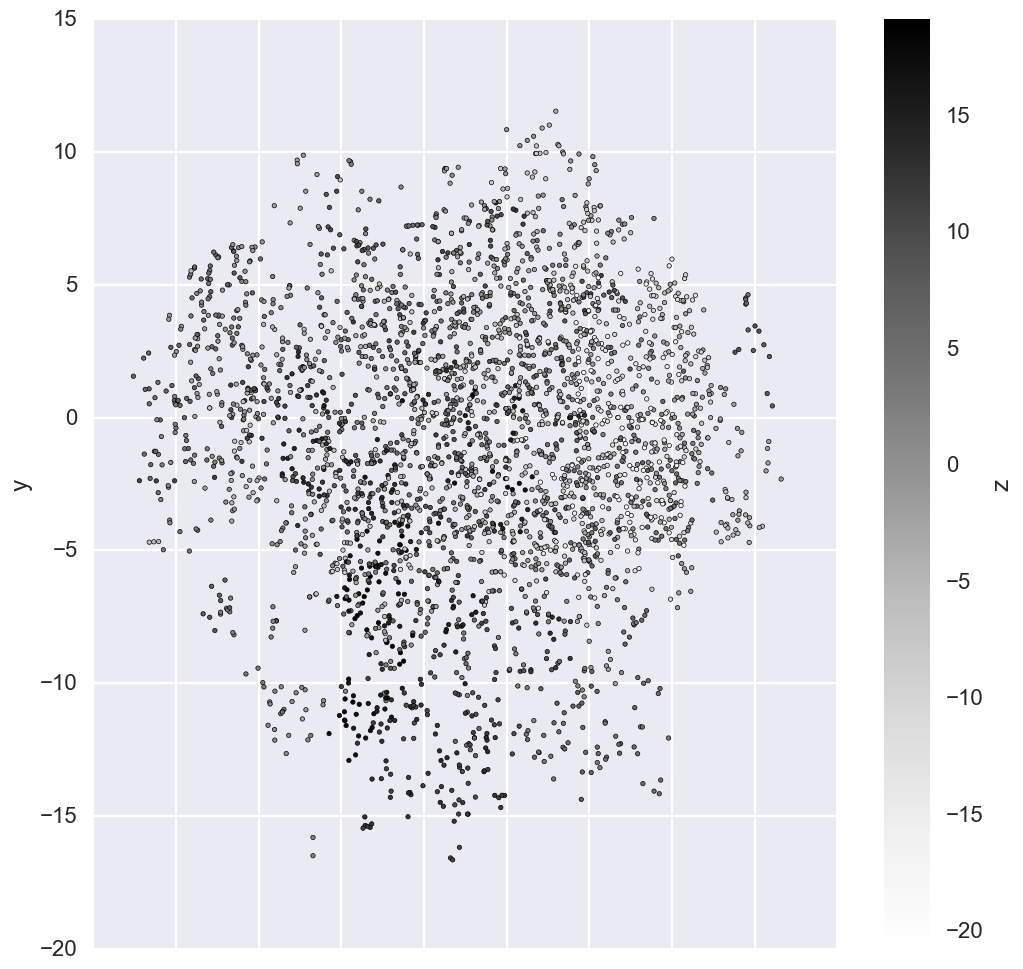

In [30]:
points.plot.scatter("x", "y", c = "z",s=10, figsize=(12, 12))

### Proper noun extraction, to get a good picture of all the characters in the book.

In [31]:
all_words = points.word
all_words_df = pd.DataFrame(all_words)
all_words_list = all_words_df['word'].values.tolist()
str_words = ' '.join(all_words_list)
#str_words

In [32]:
essays = str_words
tokens = nltk.word_tokenize(essays)
tagged = nltk.pos_tag(tokens)
nouns = [word for word,pos in tagged if (pos == 'NNP') or (pos == 'NNPS')]
print ("Number of nouns is {}.".format(len(nouns)))

#join into a string
joined = "\n".join(nouns).encode('utf-8')
into_string = str(nouns)

#write in an csv file
#output = open("Proper_noun.csv", "w")
#output.write(joined)
#output.close()

#print as a table
noun_string = " ".join(nouns).encode('utf-8')
nouns_df = pd.DataFrame(nouns)
nouns_df.head(10)

Number of nouns is 427.


,0
0,Vichitravirya
1,Vrihatkshatra
2,Duryodhana
3,Upaplavya
4,Pandu
5,Unable
6,Shrila
7,Madhusudana
8,Indraprastha
9,Mahaprabhu


(-0.5, 1439.5, 1079.5, -0.5)

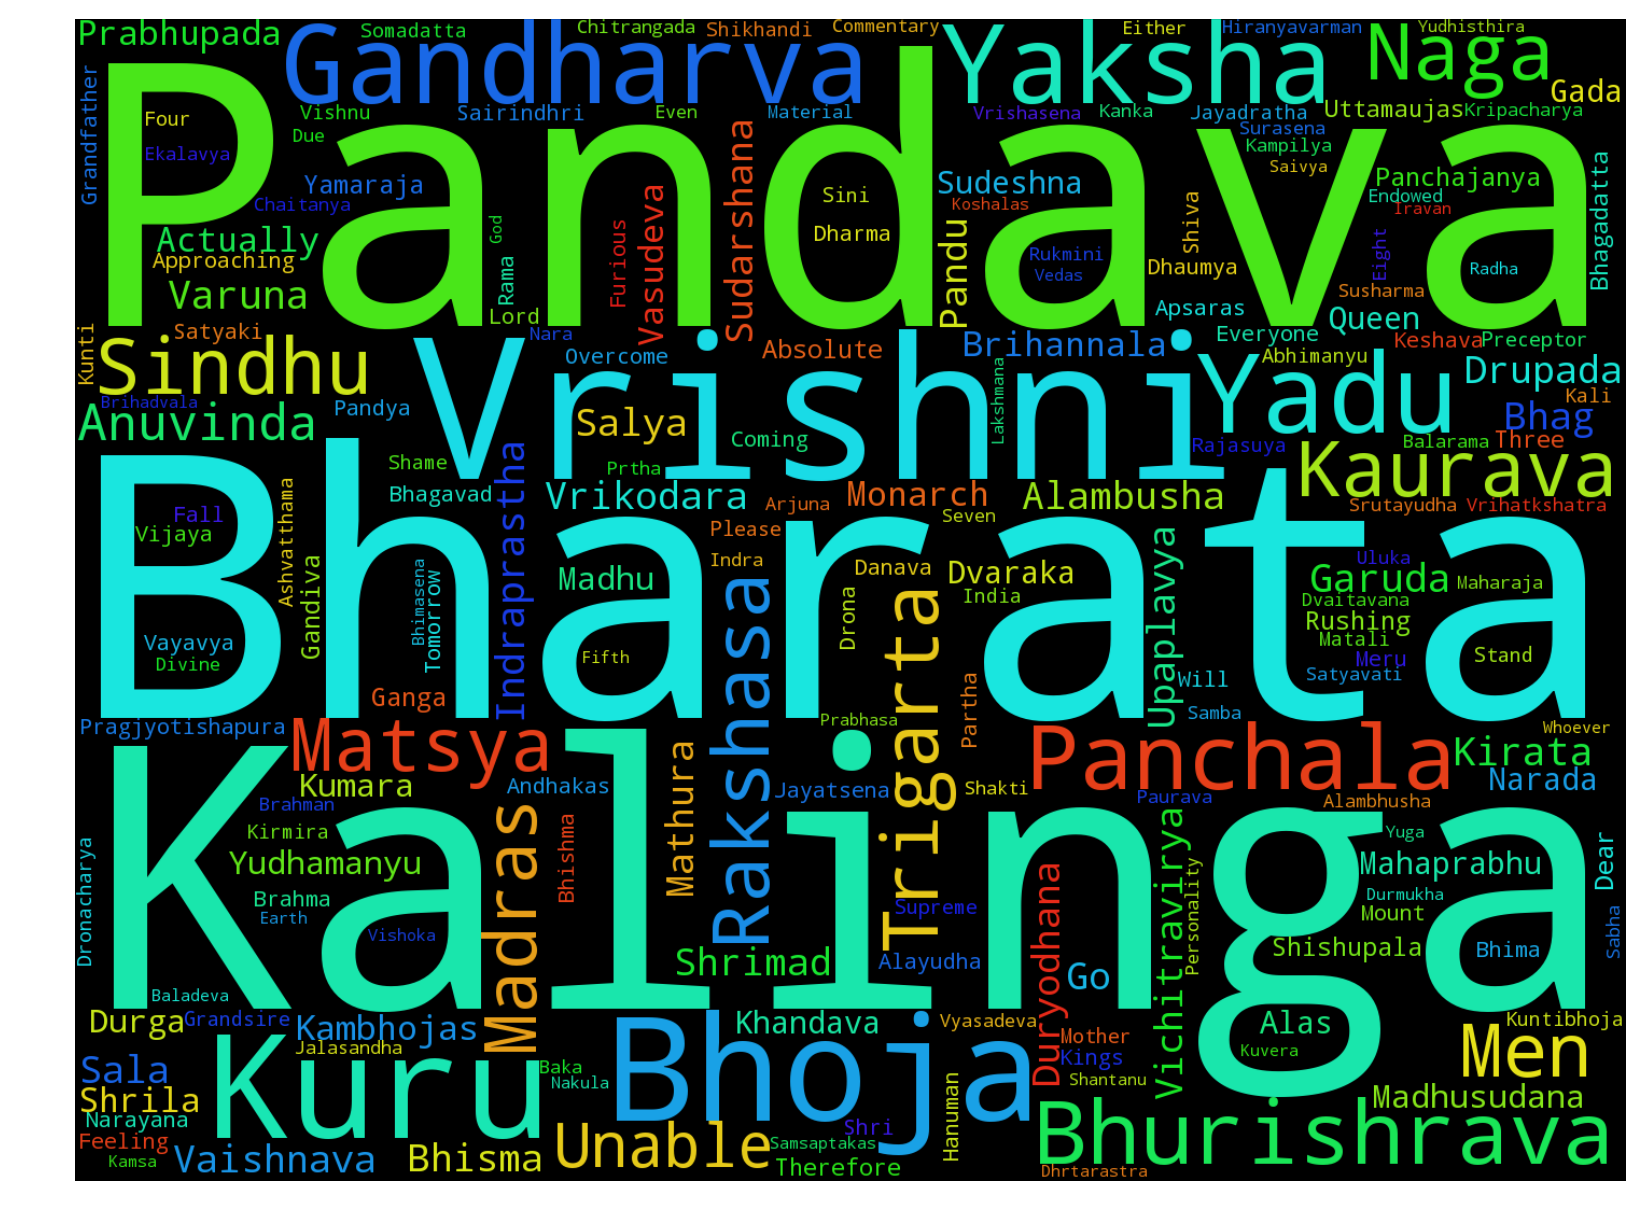

In [33]:
#conda install -c conda-forge wordcloud=1.2.1
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(noun_string)
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

In [34]:
number_noun = 0
noun_points = pd.DataFrame()
noun_string_to_word = sentence_to_wordlist(noun_string)
all_words = points.word

for noun_wrd in range(len(noun_string_to_word)):
    for wrd_sl_no in range(len(points)):
        if noun_string_to_word[noun_wrd] == all_words[wrd_sl_no]:
            noun_points_old = points.iloc[[wrd_sl_no]]
            noun_points = noun_points.append(noun_points_old)


In [35]:
type(noun_points)
#print (noun_points)
noun_points.to_csv(os.path.join("points_output", "noun_points_threeD.csv"), sep=',')

#### Scatter plot of all the proper nouns

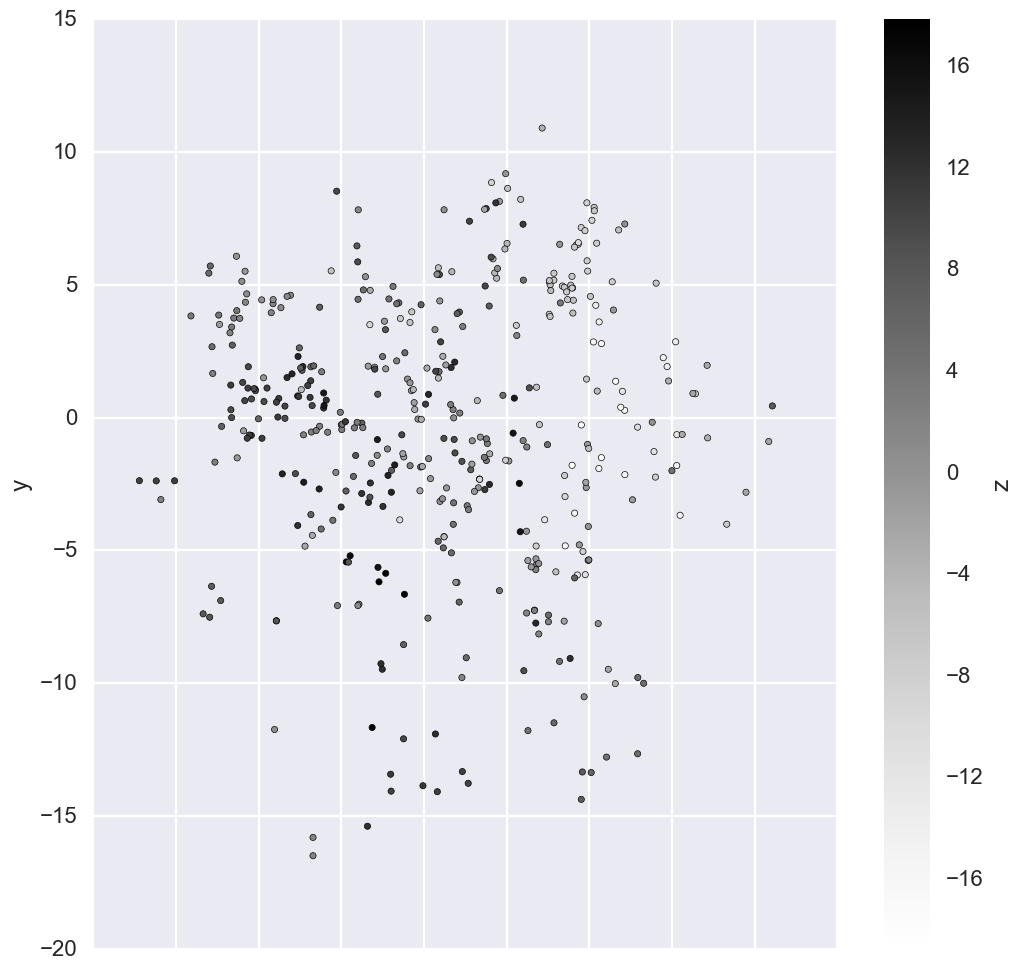

In [36]:
noun_points.plot.scatter("x", "y", c = "z", s=20, figsize=(12, 12))

#### Lets zoom in to see related characters in the book

In [37]:
def plot_region(x_bounds, y_bounds, z_bounds):
    slice = noun_points[
        (x_bounds[0] <= noun_points.x) &
        (noun_points.x <= x_bounds[1]) & 
        (y_bounds[0] <= noun_points.y) &
        (noun_points.y <= y_bounds[1]) &
        (z_bounds[0] <= noun_points.z) &
        (noun_points.z <= z_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", c = "z",s=35, figsize=(15, 15))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

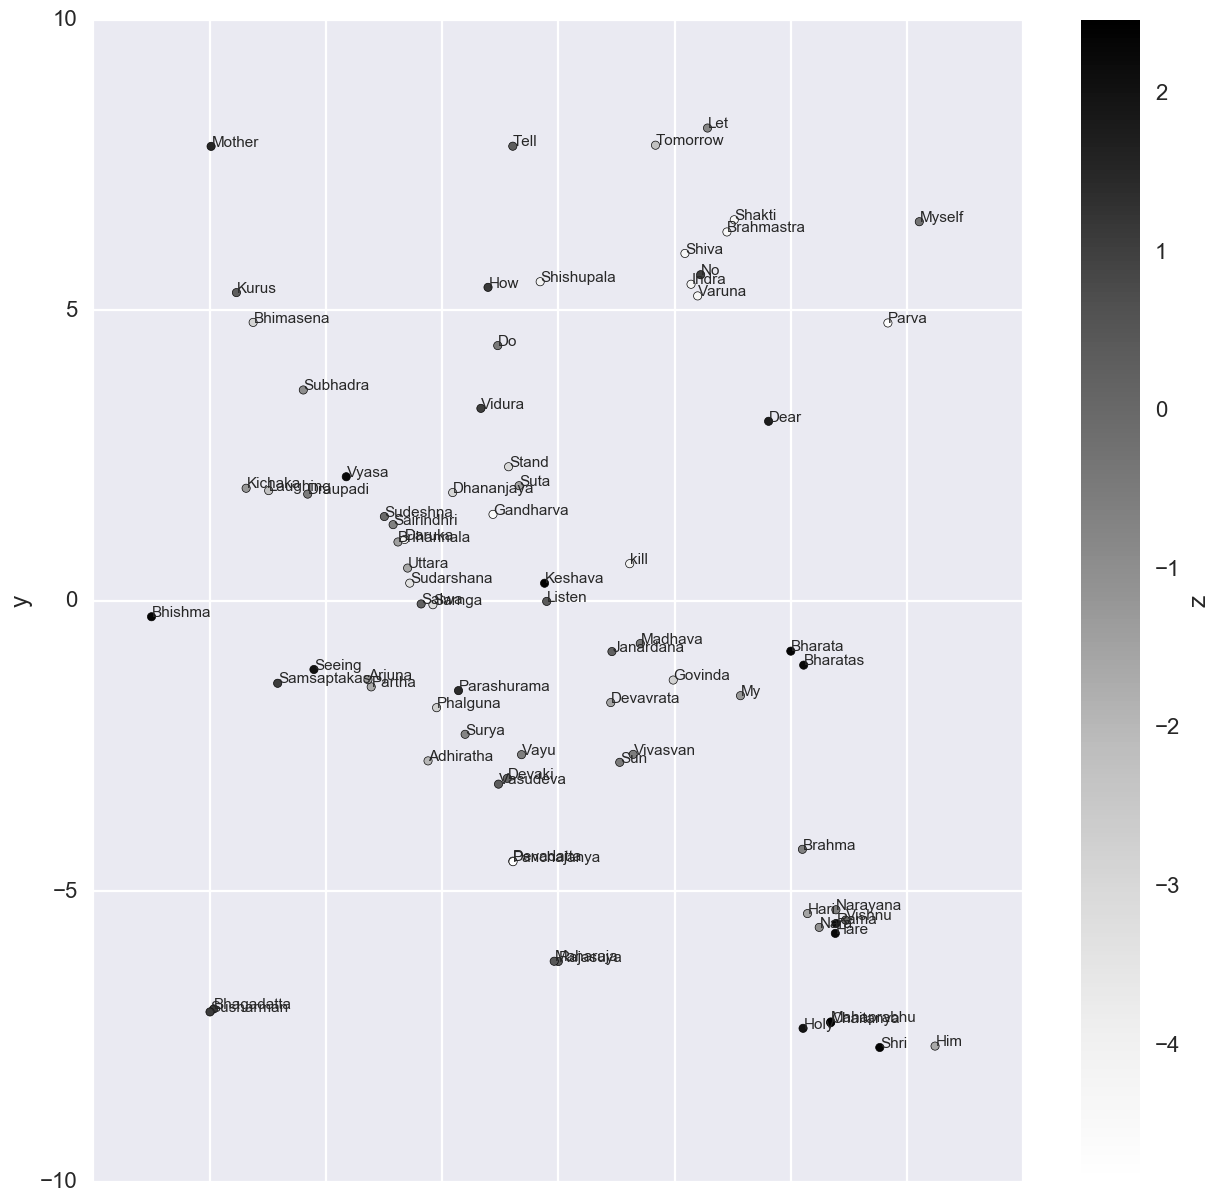

In [38]:
plot_region(x_bounds=(-5, 9), y_bounds=(-8,9), z_bounds=(-5.5,2.5))

#### Explore semantic similarities between book characters. Words closest to the given word

In [39]:
mahabharata2vec.most_similar("Krishna")

2017-03-27 04:56:35,358 : INFO : precomputing L2-norms of word weight vectors


[(u'Balarama', 0.7475441694259644),
 (u'Daruka', 0.7120652794837952),
 (u'Uddhava', 0.6923877000808716),
 (u'Baladeva', 0.676231861114502),
 (u'Shri', 0.6760291457176208),
 (u'Universe', 0.6703461408615112),
 (u'lovingly', 0.6666980385780334),
 (u'Rama', 0.6661803722381592),
 (u'displayed', 0.6645158529281616),
 (u'personally', 0.6607332229614258)]

In [40]:
mahabharata2vec.most_similar("Arjuna")

[(u'Partha', 0.7881536483764648),
 (u'Pradyumna', 0.7328255772590637),
 (u'wanting', 0.720531165599823),
 (u'Sini', 0.714367687702179),
 (u'grandson', 0.6950180530548096),
 (u'Iravan', 0.6927887797355652),
 (u'Samsaptakas', 0.6923163533210754),
 (u'Bhishma', 0.6913379430770874),
 (u'challenging', 0.6866294741630554),
 (u'endeavored', 0.6815285682678223)]

In [41]:
mahabharata2vec.most_similar("Karna")

[(u'Ashvatthama', 0.8626600503921509),
 (u'Salya', 0.8610283732414246),
 (u'Drona', 0.8493854999542236),
 (u'Kripa', 0.7998135089874268),
 (u'Bhurishravas', 0.7972800135612488),
 (u'Bhishma', 0.7908821702003479),
 (u'Bahlika', 0.7906923294067383),
 (u'Jayadratha', 0.7837864756584167),
 (u'teacher', 0.7787774801254272),
 (u'Sala', 0.7735044956207275)]

In [42]:
mahabharata2vec.most_similar("Karna")

[(u'Ashvatthama', 0.8626600503921509),
 (u'Salya', 0.8610283732414246),
 (u'Drona', 0.8493854999542236),
 (u'Kripa', 0.7998135089874268),
 (u'Bhurishravas', 0.7972800135612488),
 (u'Bhishma', 0.7908821702003479),
 (u'Bahlika', 0.7906923294067383),
 (u'Jayadratha', 0.7837864756584167),
 (u'teacher', 0.7787774801254272),
 (u'Sala', 0.7735044956207275)]

#### Answer relationship questions

In [43]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = mahabharata2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    
    #print("{start1} is related to {end1} as {start2} is related to {end2}".format(**locals()))
    #write in an csv file
    output = open("Output_relations.csv", "a")
    output.write("{} is related to {} as {} is related to {}\n".format(start1,end1,start2,end2))
    output.close()
    
    return start2

## Read all the test cases in the test documnet.

In [44]:
# Read test relation data
import pandas as pd
relation_data = pd.read_csv("test_relations.csv")
print ("Relation data read successfully!")
relation_data.head(5)

Relation data read successfully!


,Son,Father,Son2,Mother,Husband,Wife,Brothers1_1,Brothers1_2,Brothers2_1,Brothers2_2
0,Devavrata,Shantanu,Devavrata,Ganga,Shantanu,Ganga,Pandu,Dhritarastra,Bhima,Arjuna
1,Bhishma,Shantanu,Bhishma,Ganga,Shantanu,Satyavati,Pandu,Vidura,Bhima,Yudhisthira
2,Vichitravirya,Shantanu,Vichitravirya,Satyavati,Vichitravirya,Ambalika,Dhritarastra,Pandu,Bhima,Nakula
3,Chitrangada,Shantanu,Chitrangada,Satyavati,Vichitravirya,Ambika,Dhritarastra,Vidura,Bhima,Sahadeva
4,Dhritarastra,Vichitravirya,Dhritarastra,Ambika,Dhritarastra,Gandhari,Vidura,Pandu,Arjuna,Bhima


### Answer all the relationship questions and write it in a file.

In [45]:
#Test all combinations of the above relations:
#row 0 with all other rows, then row 1 with all the rows ....
father_son_control = len([x for x in (relation_data.Son) if str(x) != 'nan']) - 2 
mother_son_control = len([x for x in (relation_data.Son2) if str(x) != 'nan']) - 2 
husband_wife_control = len([x for x in (relation_data.Wife) if str(x) != 'nan']) - 2 
brothers_control = len([x for x in (relation_data.Brothers1_1) if str(x) != 'nan']) - 2
brothers2_control = len([x for x in (relation_data.Brothers2_1) if str(x) != 'nan']) - 2


#open file for appending
output = open("Output_relations.csv", "w")
output.write("Predicted_Relationship\n") #Column name

#Finding son given father
print("Finding son given father")
for col_number in range(len(relation_data.Son)):
    if ((col_number-1) < father_son_control):
        for col_number_2 in range(len(relation_data.Son)):
            if ((col_number_2) < father_son_control):
                son_data = nearest_similarity_cosmul(relation_data.Son[col_number],
                                                     relation_data.Father[col_number],
                                                     relation_data.Father[(col_number_2)+1])

#Finding son given mother
print("Finding son given mother")
for col_number in range(len(relation_data.Son2)):
    if ((col_number-1) < mother_son_control):
        for col_number_2 in range(len(relation_data.Son2)):
            if ((col_number_2) < mother_son_control):
                son_mom_data = nearest_similarity_cosmul(relation_data.Son2[col_number],
                                                         relation_data.Mother[col_number],
                                                         relation_data.Mother[col_number_2+1])


#Finding Brother given Brother - Set 1
print("Finding Brother given Brother  - Set 1")
for col_number in range(len(relation_data.Brothers1_1)):
    if ((col_number-1) < brothers_control):
        for col_number_2 in range(len(relation_data.Brothers1_1)):
            if ((col_number_2) < (brothers_control+1)):
                nearest_similarity_cosmul(relation_data.Brothers1_1[col_number],
                                          relation_data.Brothers1_2[col_number],
                                          relation_data.Brothers1_2[col_number_2+1])

#Finding Brother given Brother - Set 2
print("Finding Brother given Brother  - Set 2")
for col_number in range(len(relation_data.Brothers2_1)):
    if ((col_number-1) < brothers2_control):
        for col_number_2 in range(len(relation_data.Brothers2_1)):
            if ((col_number_2) < (brothers2_control+1)):
                nearest_similarity_cosmul(relation_data.Brothers2_1[col_number],
                                          relation_data.Brothers2_2[col_number],
                                          relation_data.Brothers2_2[col_number_2+1])

                
print("Done!!")
output.close()

Finding son given father
Finding son given mother
Finding Brother given Brother  - Set 1
Finding Brother given Brother  - Set 2
Done!!


# Generating an excel file which contains all correct answers, Should be run only once.

In [46]:
correct_output = open("Correct_relations.csv", "w")
correct_output.write("Correct_Relationship\n") #Column name
    
father_son_control = len(relation_data.Son) - 2 
mother_son_control = len(relation_data.Son2) - 2 
husband_wife_control = len([x for x in (relation_data.Wife) if str(x) != 'nan']) - 2 
brothers_control = len([x for x in (relation_data.Brothers1_1) if str(x) != 'nan']) - 2
brothers2_control = len([x for x in (relation_data.Brothers2_1) if str(x) != 'nan']) - 2

print("Finding right son given father")
for col_number in range(len(relation_data.Son)):
    if ((col_number-1) < father_son_control):
        for col_number_2 in range(len(relation_data.Son)):
            if ((col_number_2) < father_son_control):
                correct_output.write("{} is related to {} as {} is related to {}\n".format(relation_data.Son[col_number],
                                                                                           relation_data.Father[col_number],
                                                                                           relation_data.Son[col_number_2+1],
                                                                                           relation_data.Father[col_number_2+1]))
                
                
#Finding right father given son
print("Finding right father given son")
for col_number in range(len(relation_data.Son)):
    if ((col_number-1) < father_son_control):
        for col_number_2 in range(len(relation_data.Son)):
            if ((col_number_2) < father_son_control):
                correct_output.write("{} is related to {} as {} is related to {}\n".format(relation_data.Father[col_number],
                                                                                           relation_data.Son[col_number],
                                                                                           relation_data.Father[col_number_2+1],
                                                                                           relation_data.Son[col_number_2+1]))

#Finding right son given mother
print("Finding right son given mother")
for col_number in range(len(relation_data.Son2)):
    if ((col_number-1) < mother_son_control):
        for col_number_2 in range(len(relation_data.Son2)):
            if ((col_number_2) < mother_son_control):
                correct_output.write("{} is related to {} as {} is related to {}\n".format(relation_data.Son2[col_number],
                                                                                           relation_data.Mother[col_number],
                                                                                           relation_data.Son2[col_number_2+1],
                                                                                           relation_data.Mother[col_number_2+1]))
                
#Finding right mother given son
print("Finding right mother given son")
for col_number in range(len(relation_data.Son2)):
    if ((col_number-1) < mother_son_control):
        for col_number_2 in range(len(relation_data.Son2)):
            if ((col_number_2) < mother_son_control):
                correct_output.write("{} is related to {} as {} is related to {}\n".format(relation_data.Mother[col_number],
                                                                                          relation_data.Son2[col_number],
                                                                                           relation_data.Mother[col_number_2+1],
                                                                                           relation_data.Son2[col_number_2+1]))

#Finding right Husband given Wife
print("Finding right Husband given Wife")
for col_number in range(len(relation_data.Husband)):
    if ((col_number-1) < husband_wife_control):
        for col_number_2 in range(len(relation_data.Husband)):
            if ((col_number_2) < husband_wife_control):
                correct_output.write("{} is related to {} as {} is related to {}\n".format(relation_data.Husband[col_number],
                                                                                           relation_data.Wife[col_number],
                                                                                           relation_data.Husband[col_number_2+1],
                                                                                           relation_data.Wife[col_number_2+1]))

#Finding right Wife given Husband
print("Finding right Wife given Husband")
for col_number in range(len(relation_data.Husband)):
    if ((col_number-1) < husband_wife_control):
        for col_number_2 in range(len(relation_data.Husband)):
            if ((col_number_2) < husband_wife_control):
                correct_output.write("{} is related to {} as {} is related to {}\n".format(relation_data.Wife[col_number],
                                                                                           relation_data.Husband[col_number],
                                                                                           relation_data.Wife[col_number_2+1],
                                                                                           relation_data.Husband[col_number_2+1]))

#Finding right Brother given Brother - Set 1
print("Finding right Brother given Brother  - Set 1")
for col_number in range(len(relation_data.Brothers1_1)):
    if ((col_number-1) < brothers_control):
        for col_number_2 in range(len(relation_data.Brothers1_1)):
            if ((col_number_2) < (brothers_control+1)):
                correct_output.write("{} is related to {} as {} is related to {}\n".format(relation_data.Brothers1_1[col_number],
                                                                                           relation_data.Brothers1_2[col_number],
                                                                                           relation_data.Brothers1_1[col_number_2+1],
                                                                                           relation_data.Brothers1_2[col_number_2+1]))

#Finding right Brother given Brother - Set 2
print("Finding right Brother given Brother  - Set 2")
for col_number in range(len(relation_data.Brothers2_1)):
    if ((col_number-1) < brothers2_control):
        for col_number_2 in range(len(relation_data.Brothers2_1)):
            if ((col_number_2) < (brothers2_control+1)):
                correct_output.write("{} is related to {} as {} is related to {}\n".format(relation_data.Brothers2_1[col_number],
                                                                                           relation_data.Brothers2_2[col_number],
                                                                                           relation_data.Brothers2_1[col_number_2+1],
                                                                                           relation_data.Brothers2_2[col_number_2+1]))               
                
correct_output.close()

Finding right son given father
Finding right father given son
Finding right son given mother
Finding right mother given son
Finding right Husband given Wife
Finding right Wife given Husband
Finding right Brother given Brother  - Set 1
Finding right Brother given Brother  - Set 2


# Compare correct relations with the output relationship file

In [47]:
# Read output data
predicted_data = pd.read_csv("Output_relations.csv")
print ("Predicted correct data read successfully!")

# Read correct data
correct_data = pd.read_csv("Correct_relations.csv")
print ("Correct data read successfully!")

Predicted correct data read successfully!
Correct data read successfully!


In [48]:
n_predict = len(predicted_data)  #number of rows in the csv file
n_correct = len(correct_data)  #number of rows in the csv file
print ("Total number of predicted relations is {}.".format(n_predict))

Total number of predicted relations is 836.


In [49]:
predicted_data.head(10)

,Predicted_Relationship
0,Shantanu as Satyavati is related to Shantanu
1,Devavrata is related to Shantanu as Satyavati ...
2,Devavrata is related to Shantanu as Satyavati ...
3,Devavrata is related to Shantanu as rites is r...
4,Devavrata is related to Shantanu as rites is r...
5,Devavrata is related to Shantanu as rites is r...
6,Devavrata is related to Shantanu as uncles is ...
7,Devavrata is related to Shantanu as uncles is ...
8,Devavrata is related to Shantanu as uncles is ...
9,Devavrata is related to Shantanu as uncles is ...


In [50]:
correct_data.head(10)

,Correct_Relationship
0,Devavrata is related to Shantanu as Bhishma is...
1,Devavrata is related to Shantanu as Vichitravi...
2,Devavrata is related to Shantanu as Chitrangad...
3,Devavrata is related to Shantanu as Dhritarast...
4,Devavrata is related to Shantanu as Pandu is r...
5,Devavrata is related to Shantanu as Vidura is ...
6,Devavrata is related to Shantanu as Yudhisthir...
7,Devavrata is related to Shantanu as Bhima is r...
8,Devavrata is related to Shantanu as Arjuna is ...
9,Devavrata is related to Shantanu as Nakula is ...


# Accuarcy calculation

In [51]:
count = 0
cycles = 0
for row_number in range(n_predict):
    for correct_relationship_row_number in range(n_correct):
        if (predicted_data.Predicted_Relationship[row_number] == correct_data.Correct_Relationship[correct_relationship_row_number]):
            count +=1
    cycles +=1
    #print ("Cycle count is {} out of {} cycles.".format(cycles,n_predict))
print("Number of correct predictions is {}.".format(count))
accuracy = ((count)/(n_predict))*100
print ("Accuracy of the model is {}%.".format(accuracy))

Number of correct predictions is 110.
Accuracy of the model is 13.1578947368%.
